## Introduction

An example of node classification on a homogeneous graph using the `Node2Vec` representation learning algorithm. The example uses components from the `stellargraph`, `Gensim`, and `scikit-learn` libraries.

**Note:** For clarity of exposition, this notebook forgoes the use of standard machine learning practices such as `Node2Vec` parameter tuning, node feature standarization, data splitting that handles class imbalance, classifier selection, and classifier tuning to maximize predictive accuracy. We leave such improvements to the reader.

### References

**1.** Node2Vec: Scalable Feature Learning for Networks. A. Grover, J. Leskovec. ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD), 2016. ([link](https://snap.stanford.edu/node2vec/))

**2.** Distributed representations of words and phrases and their compositionality. T. Mikolov, I. Sutskever, K. Chen, G. S. Corrado, and J. Dean.  In Advances in Neural Information Processing Systems (NIPS), pp. 3111-3119, 2013. ([link](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf))

**3.** Gensim: Topic modelling for humans. ([link](https://radimrehurek.com/gensim/))

**4.** scikit-learn: Machine Learning in Python ([link](http://scikit-learn.org/stable/))

In [ ]:
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

import os
import networkx as nx
import numpy as np
import pandas as pd


from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph

%matplotlib inline

### Dataset


The dataset is the citation network Cora.

It can be downloaded by clicking [here](https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz)

The following is the description of the dataset from the publisher,

> The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words. The README file in the dataset provides more details. 

For this demo, we ignore the word vectors associated with each paper. We are only interested in the network structure and the **subject** attribute of each paper.

Download and unzip the cora.tgz file to a location on your computer. 

We assume that the dataset is stored in the directory

`../data/cora/`

where the files `cora.cites` and `cora.content` can be located.

We are going to load the data into a networkx object.

In [2]:
data_dir = "../data/cora"

In [3]:
cora_location = os.path.expanduser(os.path.join(data_dir, "cora.cites"))
g_nx = nx.read_edgelist(path=cora_location)

# load the node attribute data
cora_data_location = os.path.expanduser(os.path.join(data_dir, "cora.content"))
node_attr = pd.read_csv(cora_data_location, sep='\t', header=None)
values = { str(row.tolist()[0]): row.tolist()[-1] for _, row in node_attr.iterrows()}
nx.set_node_attributes(g_nx, values, 'subject')

# Select the largest connected component. For clarity we ignore isolated
# nodes and subgraphs; having these in the data does not prevent the
# algorithm from running and producing valid results.
g_nx_ccs = (g_nx.subgraph(c).copy() for c in nx.connected_components(g_nx))
g_nx = max(g_nx_ccs, key=len)
print("Largest subgraph statistics: {} nodes, {} edges".format(
    g_nx.number_of_nodes(), g_nx.number_of_edges()))

Largest subgraph statistics: 2485 nodes, 5069 edges


Load the features and subject for the nodes

In [4]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_table(os.path.join(data_dir, "cora.content"), header=None, names=column_names)

In [5]:
node_data.index = node_data.index.map(str)
node_data = node_data[node_data.index.isin(list(g_nx.nodes()))]

In [6]:
node_data.head()

,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,...,w_1424,w_1425,w_1426,w_1427,w_1428,w_1429,w_1430,w_1431,w_1432,subject
31336,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1061127,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
1106406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
13195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
37879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


### The Node2Vec algorithm

The Node2Vec algorithm introduced in [1] is a 2-step representation learning algorithm. The two steps are,

1. Use 2nd order random walks to generate sentences from a graph. A sentence is a list of node ids. The set of all sentences makes a corpus.

2. The corpus is then used to learn an embedding vector for each node in the graph. Each node id is considered a unique word/token in a dictionary that has size equal to the number of nodes in the graph. The Word2Vec algorithm, [2], is used for calculating the embedding vectors.


## Corpus generation using random walks

The stellargraph library provides an implementation for 2nd order random walks as required by Node2Vec. The random walks have fixed maximum length and are controlled by two parameters `p` and `q`. See [1] for a detailed description of these parameters. 

We are going to set the parameters that control the random walker's behaviour.

In [7]:
random_walk_length = 100
num_walks_per_node = 10
p = 1.
q = 1.

In [8]:
g = StellarGraph(g_nx)

In [9]:
print(g.info())

StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 5069

 Node types:
  default: [2485]
        Attributes: {'subject'}
    Edge types: default-default->default

 Edge types:
    default-default->default: [5069]



In [10]:
rw = BiasedRandomWalk(g)

walks = rw.run(nodes=list(g_nx.nodes()), # root nodes
               length=random_walk_length,  # maximum length of a random walk
               n=num_walks_per_node,        # number of random walks per root node 
               p=p,       # Defines (unormalised) probability, 1/p, of returning to source node
               q=q        # Defines (unormalised) probability, 1/q, for moving away from source node
              )
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 24850


What does the results of a random walk, i.e., sentence, look like? 

In [11]:
walks[0][:10]

['35',
 '54129',
 '593022',
 '1128946',
 '227178',
 '96847',
 '594025',
 '96847',
 '6163',
 '124064']

### Representation Learning using Word2Vec

We use the `Word2Vec`, [2], implementation in the free Python library `Gensim`, [3], to learn representations for each node in the graph.

We need to specify the dimensionality of the embedding vectors and the context window size.

In [12]:
embedding_dim = 128 
context_window_size = 5

In [13]:
from gensim.models import Word2Vec

model = Word2Vec(walks, size=embedding_dim, window=context_window_size, min_count=0, sg=1, workers=2, iter=1)

In [14]:
# The embedding vectors can be retrieved from model.wv using the node ID as key.
model.wv['19231'].shape

(128,)

In [15]:
model.wv['19231'][:32]  # showing just the first 32 dimensions

array([-0.17111883,  0.7802869 , -0.05663333,  0.28144872, -0.19702926,
        0.24845293,  0.5020827 ,  0.6107449 ,  0.3335338 , -0.23785263,
        0.3707914 ,  0.42695194,  0.591664  ,  0.4936101 ,  0.32460976,
        0.1312001 , -0.45115438,  0.30443156, -0.16403173, -0.561562  ,
        0.15787657,  0.26064482,  0.78074014, -0.28588852,  0.239538  ,
       -0.43024933,  0.25419247, -0.10684253, -0.32884377, -0.11435532,
        0.39853266,  0.8953813 ], dtype=float32)

### Visualise Node Embeddings

We retrieve the `Word2Vec` node embeddings and then we project them down to 2 dimensions using the [t-SNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) algorithm.

In [16]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [g_nx.node[node_id]['subject'] for node_id in node_ids]

In [17]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

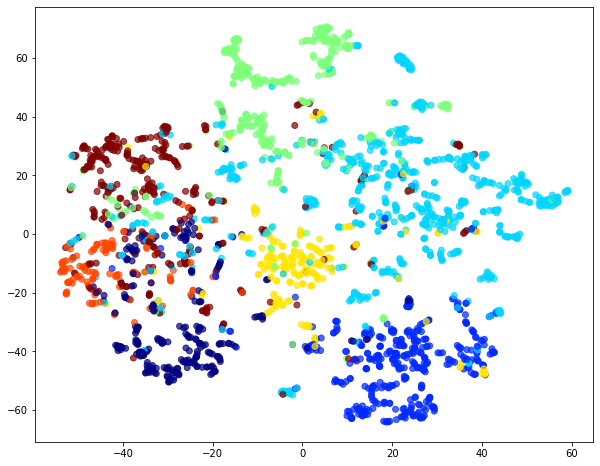

In [18]:
# draw the points
alpha=0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(10,8))
plt.scatter(node_embeddings_2d[:,0], 
            node_embeddings_2d[:,1], 
            c=node_colours, cmap="jet", alpha=alpha)

### Downstream task

The node embeddings calculated using `Word2Vec` can be used as feature vectors in a downstream task such as node attribute inference. 

In this example, we will use the `Node2Vec` node embeddings to train a classifier to predict the subject of a paper in Cora.

In [19]:
# X will hold the 128-dimensional input features
X = node_embeddings  
# y holds the corresponding target values
y = np.array(node_targets)

### Data Splitting

We split the data into train and test sets. 

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=140, 
                                                    test_size=None, 
                                                    random_state=42)

In [21]:
print("Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

Array shapes:
 X_train = (140, 128)
 y_train = (140,)
 X_test = (2345, 128)
 y_test = (2345,)


### Classifier Training

We train a Logistic Regression classifier on the training data. 

In [22]:
clf = LogisticRegressionCV(Cs=10, 
                           cv=5, 
                           verbose=False,
                           multi_class='multinomial', 
                           max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1000, multi_class='multinomial', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=False)

In [23]:
print("score on X_train {}".format(clf.score(X_train, y_train)))
print("score on X_test {}".format(clf.score(X_test, y_test)))

score on X_train 0.9142857142857143
score on X_test 0.7373134328358208


#### Exercise: improve the model trying different parameters. Add word attributes to the embeddings and run logistic regression